**Libraries and file**

In [1]:
# Import libraries
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
# Import file and read first 10 words **the file should contain one word per row**
names = open('names.txt', 'r').read().splitlines()
names[:10]

['BELLA',
 'LUCY',
 'SADIE',
 'MAX',
 'BUDDY',
 'BAILEY',
 'CHARLIE',
 'DAISY',
 'JACK',
 'GINGER']

**Vocabulary**

In [3]:
# Create vocabulary and the start/end token "."
char = set(''.join(names))

char_to_idx = {char: idx+1 for idx, char in enumerate(sorted(char))}
char_to_idx['.'] = 0

idx_to_char = {v: k for k, v in char_to_idx.items()}

In [4]:
# Get the vocabulary size
VOCAB_SIZE = len(idx_to_char)

**Dataset**

In [5]:
# How many characters should we get in order to predict the next one
CONTEXT_SIZE = 3

In [6]:
# Where to split data
n = int(0.9*len(names))

In [7]:
# Create dataset function
def create_dataset(names=names):

  X = []
  y = []

  for name in names:
    x_ = CONTEXT_SIZE * [0]
    for ch in name + '.':
      X.append(x_)
      y.append(char_to_idx[ch])
      x_ = x_[1:] + [char_to_idx[ch]]

  X = torch.tensor(X)
  y = torch.tensor(y)
  
  return X, y

In [8]:
# Create train and test datasets
X, y = create_dataset(names[:n])
X_test, y_test = create_dataset(names[n:])

In [9]:
# Check shape and dtype of the X and y
X.shape, X.dtype, y.shape, y.dtype

(torch.Size([84796, 3]), torch.int64, torch.Size([84796]), torch.int64)

In [10]:
# # Check shape and dtype of the X_test and y_test
X_test.shape, X_test.dtype, y_test.shape, y_test.dtype

(torch.Size([9479, 3]), torch.int64, torch.Size([9479]), torch.int64)

**Model**

In [11]:
# Model architecture
class LinearLayer:

  def __init__(self, in_features, hidden_units):
    self.W = torch.randn((in_features, hidden_units)) * 0.01
    self.b = torch.randn(hidden_units) * 0

  def __call__(self, X):
    self.out = X @ self.W + self.b
    return self.out

  def params(self):
    return [self.W] + [self.b]  # '+', ','


class BatchNormalization:

  def __init__(self, dim, training=True):
    self.training = training

    # Parameters
    self.batch_gain = torch.ones(dim)
    self.batch_bias = torch.zeros(dim)

    # Buffers
    self.all_batch_mean = torch.zeros(dim)
    self.all_batch_std = torch.ones(dim)

  def __call__(self, X):
    if self.training:
      batch_mean = X.mean(0, keepdim=True)
      batch_std = X.std(0, keepdim=True)
      with torch.no_grad():
        self.all_batch_mean = 0.99 * self.all_batch_mean + 0.01 * batch_mean
        self.all_batch_std = 0.99 * self.all_batch_std + 0.01 * batch_std
    else:
      batch_mean = self.all_batch_mean
      batch_std = self.all_batch_std

    self.out = self.batch_gain * (X - batch_mean) / batch_std + self.batch_bias
    return self.out

  def params(self):
    return [self.batch_gain, self.batch_bias]


class TanH:

  def __call__(self, X):
    self.out = torch.tanh(X)
    return self.out
  
  def params(self):
    return []


class Embeddings:

  def __init__(self, vocab_size, emb_size):
    self.emb = torch.randn((vocab_size, emb_size))

  def __call__(self, X):
    self.out = self.emb[X]
    self.out = self.out.view(self.out.shape[0], -1)
    return self.out

  def params(self):
    return [self.emb]


class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, X):
    for layer in self.layers:
      X = layer(X)
    self.out = X
    return self.out
  
  def params(self):
    return [p for layer in self.layers for p in layer.params()]

**Hyperparameters**

In [12]:
# Hyperparameters
EMB_SIZE = 20
HIDDEN_UNITS = 200
BATCH_SIZE = 32
STEPS = 300000

**Create model & set the parameters to require grad**

In [13]:
# Instantiate model
model = Sequential([
  Embeddings(VOCAB_SIZE, EMB_SIZE),
  LinearLayer(EMB_SIZE * CONTEXT_SIZE, HIDDEN_UNITS), BatchNormalization(HIDDEN_UNITS), TanH(),
  LinearLayer(HIDDEN_UNITS, HIDDEN_UNITS), BatchNormalization(HIDDEN_UNITS), TanH(),
  LinearLayer(HIDDEN_UNITS, VOCAB_SIZE),
])

In [14]:
# Set the parameters to require grad
parameters = model.params()

for p in parameters:
  p.requires_grad = True

**Forward pass**

In [15]:
# Create list to store all the loss values
loss_list = []

# Forward pass
for i in range(STEPS):

  idx = torch.randint(0, X.shape[0], (BATCH_SIZE, ))
  X_batch, y_batch = X[idx], y[idx]
  
  logits = model(X_batch)
  loss = F.cross_entropy(logits, y_batch) # loss function

  # Backpropagation
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # Lr decay
  if i < 200000:
    lr = -0.01
  elif i < 100000:
    lr = -0.1
  else:
    lr = -0.001

  # Update the parameters
  for p in parameters:
    p.data += lr * p.grad

  # Track loss every 10000 steps and append all the loss values to a list
  if i % 10000 == 0:
    print(f'{loss.item():.4f}')
  loss_list.append(loss.item())

3.3185
2.4616
2.0431
2.0191
1.8910
1.9696
2.0139
2.1667
1.9469
1.9474
1.8738
1.8404
1.5918
2.0459
1.7811
2.0652
2.3293
1.8020
1.4326
1.4245
1.5819
1.6157
1.8667
1.6163
1.7843
1.5741
1.7781
1.8490
1.7232
1.5303


**Loss curve**

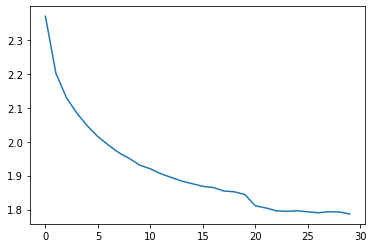

In [16]:
# Plot loss curve
plt.plot(torch.tensor(loss_list).view(-1, 10000).mean(1))

**Check test loss**

In [17]:
# Set the BN training attribute to False
for layer in model.layers:
  layer.training = False

In [18]:
# Function to calculate the loss
def check_loss(data='train'):
  with torch.no_grad():
    X_,y_ = {
      'train': (X, y),
      'test': (X_test, y_test)
    }[data]
    logits = model(X_)
    loss = F.cross_entropy(logits, y_)
  print(data, loss.item())

In [19]:
# Train loss
check_loss()

train 1.7322505712509155


In [20]:
# Test loss
check_loss('test')

test 2.0458731651306152


In [22]:
# Get 15 predictions
for _ in range(15):

  out_list = []
  context = CONTEXT_SIZE * [0]
  while True:

    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)
    idx = torch.multinomial(probs, num_samples=1).item() # Draw samples from a multinomial distribution.

    context = context[1:] + [idx]
    out_list.append(idx)
  
    if idx == 0:
      break
    
  print(''.join(idx_to_char[idx] for idx in out_list[:-1]))

PANDALF
PIPPER
BRUSHILDA
DOZER
TAMAK
HAYLA
WRENA
JULIE
BINNIE
BREEZLE
BLAZEE
PAX
BANSHINGTON
AUGE
NETO
